У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score

In [2]:
df = pd.read_csv('customer_segmentation_train.csv', index_col='ID')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Segmentation', axis = 1),
                                                    df['Segmentation'],
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=df['Segmentation']
                                                    )

In [4]:
X_train

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
ID,,,,,,,,,
465905,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6
462903,Male,Yes,72,Yes,Entertainment,NaN,Average,2.0,Cat_6
467901,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6
463613,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6
459859,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7
...,...,...,...,...,...,...,...,...,...
463101,Female,No,27,No,Homemaker,8.0,Low,1.0,Cat_6
467844,Male,No,37,Yes,Healthcare,0.0,Low,2.0,Cat_6
460706,Female,No,27,No,Engineer,6.0,Low,6.0,Cat_4


In [5]:
# Подивимось на нульові значення
df.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Бачимо, що у нас є нульові значення в багатьох колонках, тому заповнимо їх.

In [6]:
df['Ever_Married'].value_counts()

Yes    4643
No     3285
Name: Ever_Married, dtype: int64

In [7]:
df['Graduated'].value_counts()

Yes    4968
No     3022
Name: Graduated, dtype: int64

In [8]:
df['Profession'].value_counts()

Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64

Для Ever_Married, Graduated, Profession не бачу якогось вираженого значення в змінній, тому буду заміняти пропущені значення на "No info"

In [9]:
df['Work_Experience'].value_counts()

1.0     2354
0.0     2318
9.0      474
8.0      463
2.0      286
3.0      255
4.0      253
6.0      204
7.0      196
5.0      194
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: Work_Experience, dtype: int64

In [10]:
df['Work_Experience'].mean()

2.641663213150988

In [11]:
X_train['Work_Experience'].mean()

2.6714876033057853

Для Work_Experience замінимо пропущені значення на округлене середнє з тренувальної вибірки, тобто на 3 роки.

In [12]:
df['Family_Size'].value_counts()

2.0    2390
3.0    1497
1.0    1453
4.0    1379
5.0     612
6.0     212
7.0      96
8.0      50
9.0      44
Name: Family_Size, dtype: int64

In [13]:
df['Family_Size'].mean()

2.85012285012285

In [14]:
X_train['Family_Size'].mean()

2.8397415185783523

Для Family_Size замінимо пропущені значення на округлене середнє з тренувальної вибірки, тобто на 3 людини.

In [15]:
df['Var_1'].value_counts()

Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: Var_1, dtype: int64

Для Var_1 замінимо нульові значення на 'No info'

In [16]:
# Робимо усі заміни нульових хначень, які описувала вище
df=df.fillna({'Ever_Married':'No info',
              'Graduated':'No info',
              'Profession':'No info',
              'Work_Experience':3,
              'Family_Size':3,
              'Var_1':'No info'})

In [17]:
df.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

Ще раз згенеруємо трейн і тест на оновленому датафреймі

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Segmentation', axis = 1),
                                                    df['Segmentation'],
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=df['Segmentation']
                                                    )

In [19]:
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

In [20]:
# Min max scaling
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# One hot encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])

['Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_No info', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_No info', 'Graduated_Yes', 'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment', 'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing', 'Profession_No info', 'Spending_Score_Average', 'Spending_Score_High', 'Spending_Score_Low', 'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7', 'Var_1_No info']


In [21]:
display(X_train[:5], X_test[:5])

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Gender_Female,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
ID,,,,,,,,,,,,,,,,,,,,,
465905,Female,No,0.197183,Yes,Artist,0.642857,Low,1.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
462903,Male,Yes,0.760563,Yes,Entertainment,0.214286,Average,2.0,Cat_6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
467901,Female,No,0.211268,Yes,Entertainment,0.071429,Low,4.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
463613,Female,Yes,0.422535,Yes,Artist,0.000000,Average,6.0,Cat_6,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
459859,Female,Yes,0.140845,No,Doctor,0.642857,Low,1.0,Cat_7,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Gender_Female,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
ID,,,,,,,,,,,,,,,,,,,,,
462588,Male,Yes,0.323944,No,Entertainment,0.857143,Average,3.0,Cat_4,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
459767,Male,No,0.042254,No,Healthcare,0.285714,Low,4.0,Cat_6,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
463475,Female,Yes,0.253521,Yes,Doctor,0.000000,Low,1.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
465993,Female,No,0.126761,No,Engineer,0.000000,Low,2.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
459016,Female,No,0.000000,No,Healthcare,0.000000,Low,6.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
X_train_processed = X_train[numeric_cols + encoded_cols].copy()
X_test_processed = X_test[numeric_cols + encoded_cols].copy()

In [23]:
display(X_train_processed[:5], X_test_processed[:5])

,Age,Work_Experience,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_No info,Ever_Married_Yes,Graduated_No,Graduated_No info,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
ID,,,,,,,,,,,,,,,,,,,,,
465905,0.197183,0.642857,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
462903,0.760563,0.214286,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
467901,0.211268,0.071429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
463613,0.422535,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
459859,0.140845,0.642857,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,Age,Work_Experience,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_No info,Ever_Married_Yes,Graduated_No,Graduated_No info,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
ID,,,,,,,,,,,,,,,,,,,,,
462588,0.323944,0.857143,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
459767,0.042254,0.285714,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
463475,0.253521,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
465993,0.126761,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
459016,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках і порівняти лін регресію на апсампл даних без категоріальних ознак.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [42]:
!pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 258.3/258.3 kB 2.3 MB/s eta 0:00:00
     -------------------------------------- 301.8/301.8 kB 9.4 MB/s eta 0:00:00


In [24]:
pca = PCA(n_components=2)
pca.fit(X_train_processed)
X_train_pca = pca.transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)


# Encode the categorical labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

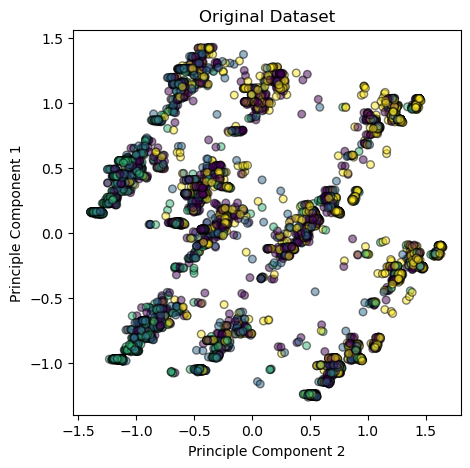

In [25]:
# Function for plotting dataset
def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

# Plot dataset
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train_encoded, ax, title='Original Dataset')

Так як будемо використовувати SMOTENC для генерування категоріальних змінних, доведеться знову спочатку розбити датасет на тренувальний і тестувальний набори, а потім нагенерувати ктегоріальних кейсів на тренувальному датасеті, і потім обробити їх one hot encoder.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Segmentation', axis = 1),
                                                    df['Segmentation'],
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=df['Segmentation']
                                                    )

In [27]:
X_train

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
ID,,,,,,,,,
465905,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6
462903,Male,Yes,72,Yes,Entertainment,3.0,Average,2.0,Cat_6
467901,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6
463613,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6
459859,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7
...,...,...,...,...,...,...,...,...,...
463101,Female,No,27,No,Homemaker,8.0,Low,1.0,Cat_6
467844,Male,No,37,Yes,Healthcare,0.0,Low,2.0,Cat_6
460706,Female,No,27,No,Engineer,6.0,Low,6.0,Cat_4


Оверсемплінг з SMOTENC

In [28]:
print("The original imbalanced dataset")
print(sorted(Counter(y_train).items()))
print()
print("The first and last columns are containing categorical features:")
print(X_train[:5])
print()


smote_nc = SMOTENC(categorical_features=[0, 1, 3, 4, 6, 8], random_state=0)
X_resampled_smote_nc, y_resampled_smote_nc = smote_nc.fit_resample(X_train, y_train)
print("Dataset after resampling:")
print(sorted(Counter(y_resampled_smote_nc).items()))
print()
print("SMOTE-NC will generate categories for the categorical features:")
print(X_resampled_smote_nc[-5:])
print()

The original imbalanced dataset
[('A', 1578), ('B', 1486), ('C', 1576), ('D', 1814)]

The first and last columns are containing categorical features:
        Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
ID                                                                           
465905  Female           No   32       Yes         Artist              9.0   
462903    Male          Yes   72       Yes  Entertainment              3.0   
467901  Female           No   33       Yes  Entertainment              1.0   
463613  Female          Yes   48       Yes         Artist              0.0   
459859  Female          Yes   28        No         Doctor              9.0   

       Spending_Score  Family_Size  Var_1  
ID                                         
465905            Low          1.0  Cat_6  
462903        Average          2.0  Cat_6  
467901            Low          4.0  Cat_6  
463613        Average          6.0  Cat_6  
459859            Low          1.0  Cat

In [29]:
X_resampled_smote_nc

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Female,No,32,Yes,Artist,9.000000,Low,1.000000,Cat_6
1,Male,Yes,72,Yes,Entertainment,3.000000,Average,2.000000,Cat_6
2,Female,No,33,Yes,Entertainment,1.000000,Low,4.000000,Cat_6
3,Female,Yes,48,Yes,Artist,0.000000,Average,6.000000,Cat_6
4,Female,Yes,28,No,Doctor,9.000000,Low,1.000000,Cat_7
...,...,...,...,...,...,...,...,...,...
7251,Female,Yes,48,Yes,Artist,1.000000,High,3.350537,Cat_6
7252,Female,No,31,No,Healthcare,1.000000,Low,4.460776,Cat_6
7253,Female,Yes,66,Yes,Lawyer,1.325685,High,2.674315,Cat_6
7254,Female,No,26,Yes,Artist,0.852986,Low,8.852986,Cat_6


In [30]:
X_train

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
ID,,,,,,,,,
465905,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6
462903,Male,Yes,72,Yes,Entertainment,3.0,Average,2.0,Cat_6
467901,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6
463613,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6
459859,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7
...,...,...,...,...,...,...,...,...,...
463101,Female,No,27,No,Homemaker,8.0,Low,1.0,Cat_6
467844,Male,No,37,Yes,Healthcare,0.0,Low,2.0,Cat_6
460706,Female,No,27,No,Engineer,6.0,Low,6.0,Cat_4


In [31]:
# Min max scaling
scaler = MinMaxScaler()
X_resampled_smote_nc[numeric_cols] = scaler.fit_transform(X_resampled_smote_nc[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# One hot encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(X_resampled_smote_nc[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)
X_resampled_smote_nc[encoded_cols] = encoder.transform(X_resampled_smote_nc[categorical_cols])
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])

['Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_No info', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_No info', 'Graduated_Yes', 'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment', 'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing', 'Profession_No info', 'Spending_Score_Average', 'Spending_Score_High', 'Spending_Score_Low', 'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7', 'Var_1_No info']


In [32]:
display(X_resampled_smote_nc[:5], X_test[:5])

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Gender_Female,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
0,Female,No,0.197183,Yes,Artist,0.642857,Low,1.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Male,Yes,0.760563,Yes,Entertainment,0.214286,Average,2.0,Cat_6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Female,No,0.211268,Yes,Entertainment,0.071429,Low,4.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Female,Yes,0.422535,Yes,Artist,0.000000,Average,6.0,Cat_6,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Female,Yes,0.140845,No,Doctor,0.642857,Low,1.0,Cat_7,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Gender_Female,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
ID,,,,,,,,,,,,,,,,,,,,,
462588,Male,Yes,0.323944,No,Entertainment,0.857143,Average,3.0,Cat_4,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
459767,Male,No,0.042254,No,Healthcare,0.285714,Low,4.0,Cat_6,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
463475,Female,Yes,0.253521,Yes,Doctor,0.000000,Low,1.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
465993,Female,No,0.126761,No,Engineer,0.000000,Low,2.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
459016,Female,No,0.000000,No,Healthcare,0.000000,Low,6.0,Cat_6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
X_train_processed_smote_nc = X_resampled_smote_nc[numeric_cols + encoded_cols].copy()
X_test_processed = X_test[numeric_cols + encoded_cols].copy()

In [34]:
display(X_train_processed_smote_nc[:5], X_test_processed[:5])

,Age,Work_Experience,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_No info,Ever_Married_Yes,Graduated_No,Graduated_No info,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
0,0.197183,0.642857,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.760563,0.214286,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.211268,0.071429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.422535,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.140845,0.642857,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,Age,Work_Experience,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_No info,Ever_Married_Yes,Graduated_No,Graduated_No info,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
ID,,,,,,,,,,,,,,,,,,,,,
462588,0.323944,0.857143,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
459767,0.042254,0.285714,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
463475,0.253521,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
465993,0.126761,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
459016,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Оверсемплінг з SMOTETomek

In [37]:
smotetomek = SMOTETomek(random_state=0)
X_train_processed_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_processed, y_train)

In [38]:
X_train_smotetomek

,Age,Work_Experience,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_No info,Ever_Married_Yes,Graduated_No,Graduated_No info,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_No info
0,0.197183,0.642857,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
1,0.760563,0.214286,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
2,0.211268,0.071429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
3,0.140845,0.642857,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0
4,0.380282,0.214286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,0.243392,0.010274,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.856171,0.0,0.0,0.0,0.143829,0.0,0.0
5766,0.404240,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
5767,0.694405,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
5768,0.116817,0.071429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0


**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [42]:
# Логістична регресія зі стратегією one-vs-rest (OvR)
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)

In [47]:
# Будуємо логістичну регресію для оригінальних даних
ovr_model.fit(X_train_processed, y_train)
ovr_predictions_original = ovr_model.predict(X_test_processed)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_original))

              precision    recall  f1-score   support

           A       0.42      0.43      0.42       394
           B       0.42      0.18      0.25       372
           C       0.48      0.63      0.54       394
           D       0.65      0.76      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



In [50]:
# Будуємо логістичну регресію для даних з оверсемплінгом з SMOTENC
ovr_model.fit(X_train_processed_smote_nc, y_resampled_smote_nc)
ovr_predictions_original = ovr_model.predict(X_test_processed)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_original))

              precision    recall  f1-score   support

           A       0.41      0.46      0.43       394
           B       0.36      0.23      0.28       372
           C       0.48      0.56      0.52       394
           D       0.67      0.71      0.69       454

    accuracy                           0.50      1614
   macro avg       0.48      0.49      0.48      1614
weighted avg       0.49      0.50      0.49      1614



In [51]:
# Будуємо логістичну регресію для даних з оверсемплінгом з Smote-Tomek
ovr_model.fit(X_train_processed_smotetomek, y_train_smotetomek)
ovr_predictions_original = ovr_model.predict(X_test_processed)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_original))

              precision    recall  f1-score   support

           A       0.42      0.50      0.45       394
           B       0.39      0.21      0.27       372
           C       0.48      0.59      0.53       394
           D       0.68      0.69      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



Висновок: виглядає так, що моделька на оригінальних даних, з оверсемплінгом з SMOTENC та з оверсемплінгом з Smote-Tomek має всюди має приблизні показники якості, якщо дивитись на f1-score, який є приблизно 50% для weighted avg.
Якщо дивитись на графік scatter plot на оригінальних даних для двох principal компоментів, то видно, що в кожній групі присутні усі можливі атегорії, можливо через це ми маємо такі погані метрики якості.